In [78]:
import os

import matplotlib.pyplot as plt
import numpy as np

In [114]:
RNG_SEED = 42

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 22})
np.random.seed(seed=RNG_SEED)


def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Source: https://jwalton.info/Matplotlib-latex-PGF/"""
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    return (fig_width_in, fig_height_in)

In [115]:
class ToyDataset:
    def __init__(self, size):
        self.size = size
        mask = np.random.binomial(1, 0.8, size=(size // 2,))[:, None]
        g1 = np.random.randn(size // 2, 2) + 5
        g2 = np.random.randn(size // 2, 2) - 5
        self.ds = np.float32(g1 * mask + g2 * (1 - mask))
        self.ds_y = mask
        
        self.ds_min = self.ds.min()
        self.ds_max = self.ds.max()
        

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.ds[idx], self.ds_y[idx]

In [116]:
ds = ToyDataset(5000)

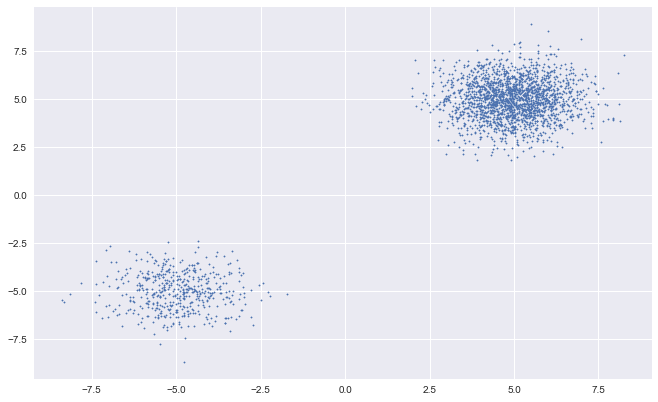

In [117]:
width, height = set_size(800)
fig, ax = plt.subplots(1, 1, figsize=(width, height))
ax.scatter(ds.ds[:, 0], ds.ds[:, 1], s=2)

In [139]:
def make_spirals(n_samples, noise_std=0., rotations=1.):
    ts = np.linspace(0, 1, n_samples)
    rs = ts ** 0.5
    thetas = rs * rotations * 2 * np.pi
    signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
    labels = (signs > 0).astype(int)

    xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
    ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
    points = np.stack([xs, ys], axis=1)
    return points, labels

points, labels = make_spirals(5000, noise_std=0.05, rotations=1.5)

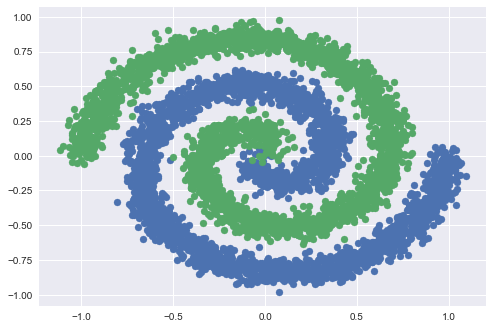

In [140]:
plt.scatter(points[np.where(labels == 0), 0], points[np.where(labels == 0), 1])
plt.scatter(points[np.where(labels == 1), 0], points[np.where(labels == 1), 1])

In [142]:
class ToyDataset:
    def __init__(self):
        self.size = 5_000
        rotations = 1.5
        noise_std = 0.05

        self.x, self.y = self._make_spirals(self.size, noise_std, rotations)

        self.ds_min = self.x.min()
        self.ds_max = self.x.max()

    def __len__(self):
        return self.size

    def _make_spirals(self, n_samples, noise_std=0.0, rotations=1.0):
        ts = np.linspace(0, 1, n_samples)
        rs = ts**0.5
        thetas = rs * rotations * 2 * np.pi
        signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
        labels = (signs > 0).astype(int)

        xs = rs * signs * np.cos(thetas) + np.random.randn(n_samples) * noise_std
        ys = rs * signs * np.sin(thetas) + np.random.randn(n_samples) * noise_std
        points = np.stack([xs, ys], axis=1)
        return points, labels

    def _normalize(self, pt):
        return (pt - self.ds_min) / (self.ds_max - self.ds_min)

    def __getitem__(self, idx):
        return {'x': self._normalize(self.x[idx]), 'y': self.y[idx]}

In [143]:
ds = ToyDataset()

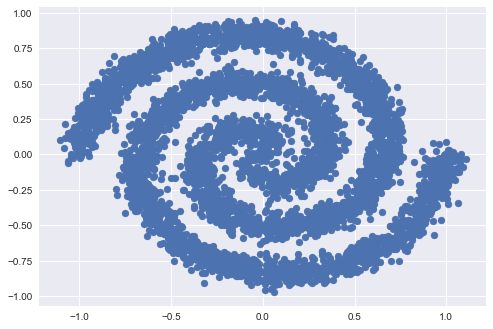

In [145]:
plt.scatter(ds.x[:, 0], ds.x[:, 1])

In [146]:
ds.y

array([0, 1, 0, ..., 0, 1, 1])